In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
import random

import torch
from torch.utils.data import Dataset

from PIL import Image

import albumentations as A
from albumentations.core.transforms_interface import DualTransform, ImageOnlyTransform
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# ShowCase of Plant Detection Augmentations

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.image_dir = image_dir
        self.annotations = pd.read_csv(csv_path)
        self.grouped_annotations = self._group_annotations(self.annotations)
        self.transform = transform

    def _group_annotations(self, dataframe):
        grouped = {}
        for _, row in dataframe.iterrows():
            image_name = row['image_name']
            image_path = os.path.join(self.image_dir, image_name)

            if os.path.isfile(image_path):
                label = row['label_name']
                bbox = [row['bbox_x'], row['bbox_y'], row['bbox_x'] + row['bbox_width'], row['bbox_y'] + row['bbox_height']]

                if image_name in grouped:
                    grouped[image_name]['boxes'].append(bbox)
                    grouped[image_name]['labels'].append(label)
                else:
                    grouped[image_name] = {
                        'boxes': [bbox],
                        'labels': [label]
                    }
        return grouped

    def __len__(self):
        return len(self.grouped_annotations)

    def __getitem__(self, idx):
        image_name = sorted(self.grouped_annotations.keys())[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        annotations = self.grouped_annotations[image_name]
        boxes = annotations['boxes']
        labels = annotations['labels']
        class_mapping = {'plant': 1}
        labels = [class_mapping.get(label, 0) for label in labels]

        if self.transform:
            image = np.array(image)
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']
        else:
            image = torch.as_tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255.0

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        return image, target

In [ ]:
def augmentations1():
    return A.Compose([
        A.Blur(blur_limit=4, p=1),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def augmentations2():
    return A.Compose([
        A.RandomBrightnessContrast(p=1),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def augmentations3():
    return A.Compose([
        A.Sharpen(p=1),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
csv = 'PATH_to_labels'
img_path = 'PATH_to_image_dir'


aug1 = CustomDataset(csv_path=csv, image_dir=img_path, transform=augmentations1())
aug2 = CustomDataset(csv_path=csv, image_dir=img_path, transform=augmentations2())
aug3 = CustomDataset(csv_path=csv, image_dir=img_path, transform=augmentations3())

In [ ]:
def plot_images_with_boxes(loaders, titles):
    fig, axs = plt.subplots(1, len(loaders), figsize=(25, 16))

    for idx, loader in enumerate(loaders):
        image, target = next(iter(loader))

        image = image.permute(1, 2, 0).cpu().numpy()

        ax = axs[idx]
        ax.imshow(image)
        ax.set_title(titles[idx])

        for box in target['boxes']:
            box = box.cpu().numpy()
            x, y, x_max, y_max = box
            width = x_max - x
            height = y_max - y
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, 'Plant', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
        ax.axis('off')

    plt.show()

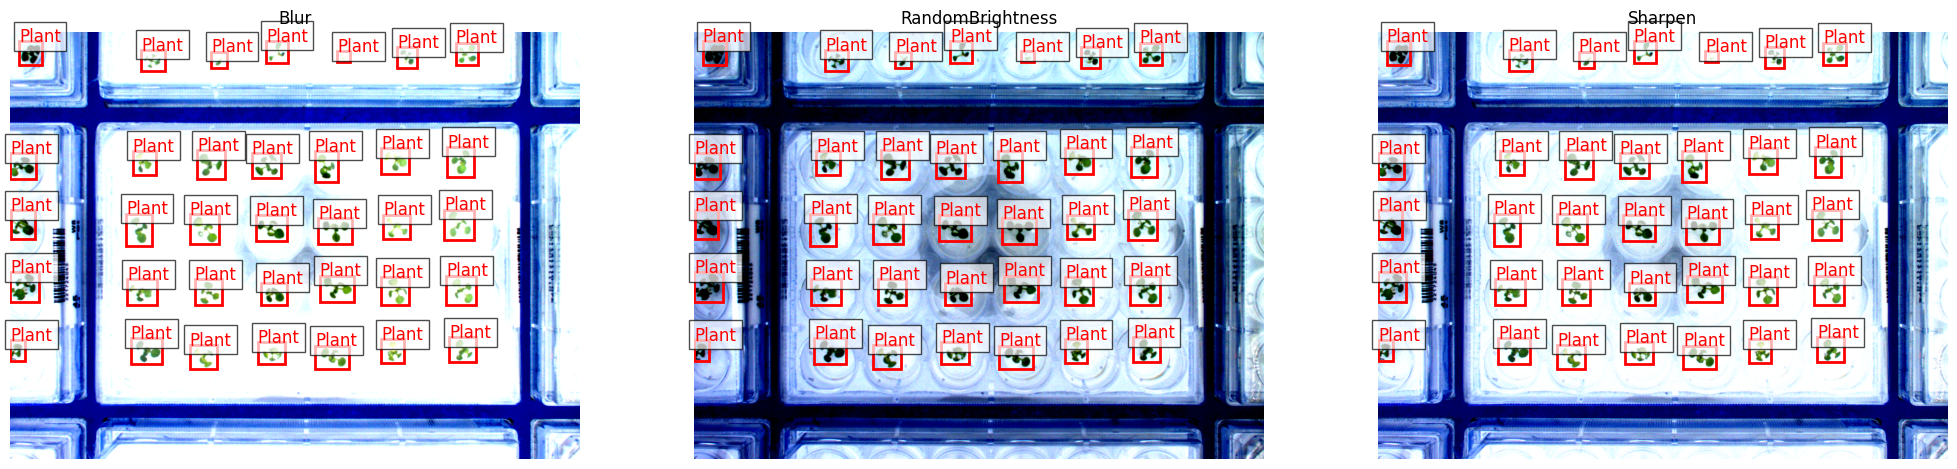

In [ ]:
loaders = [aug1, aug2, aug3]
titles = ['Blur', 'RandomBrightness', 'Sharpen']

plot_images_with_boxes(loaders, titles)